In [1]:
import zipfile

In [2]:
with zipfile.ZipFile('./lunet2.zip', 'r') as zip_ref:
    zip_ref.extractall('./lunet2')

In [3]:
with zipfile.ZipFile('/oriondata/AIMLab/renee.zac/Datasets/mbrset-a-mobile-brazilian-retinal-dataset-1.0.zip', 'r') as zip_ref:
    zip_ref.extractall('/oriondata/AIMLab/renee.zac/Datasets/mbrset')

### Variables

In [15]:
DATASET_PATH = '/oriondata/AIMLab/renee.zac/Datasets/mbrset/mbrset-a-mobile-brazilian-retinal-dataset-1.0/images/'

In [80]:
OUT_PATH = './mbrset_lunout/'

In [14]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [17]:
INPUT_SIZE = 1472

#### From RLADtoCoreML

In [1]:
import yaml
import importlib
import torch
import torch.nn as nn
import torch.distributed as dist
from safetensors.torch import load_file
from torchvision import transforms
from transformers import PreTrainedModel
import torch
from torch import nn
import numpy as np
from torch.nn.modules.loss import CrossEntropyLoss
from transformers import Swinv2PreTrainedModel
from transformers import Swinv2Config, Swinv2Model
from transformers import AutoImageProcessor
import math
from safetensors.torch import load_model, save_model

/home/renee.zac/miniforge3/envs/expl3nv.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_to_use = "large" #or tiny

In [3]:

def load_yaml(file):
    with open(file,'rt') as f:
        out = yaml.safe_load(f)
    return out


def replace_keys(s, replace_list):
    for d in replace_list:
        for key, value in d.items():
            s = s.replace(key, value)
    return s

def load_checkpoint(model, name, exception = None, replace = None):
    state_dict = load_file(name, device="cpu")
    if replace is not None:
        state_dict = {replace_keys(k, replace): v for k, v in state_dict.items()}
    if exception is not None:
        state_dict = {k: v for k, v in state_dict.items() if exception not in k}
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    missing = set(missing)
    print("missing keys: {}".format(missing))
    print("unexpected keys: {}".format(unexpected))
    return missing, unexpected


# LUNet v2 architecture

In [4]:
class Swinv2Segmenter(nn.Module):
    def __init__(self,model_args):
        super().__init__()
        self.config_ = load_yaml(model_args.model_config_path)
        self.model_arch = "swin"

        self.generated_loss_alpha = self.config_.get("generated_loss_alpha", 0.1)
        self.non_generated_loss_alpha = self.config_.get("non_generated_loss_alpha", 1.0)
        print("generated_loss_alpha", self.generated_loss_alpha)
        print("non_generated_loss_alpha", self.non_generated_loss_alpha)

        # Load the configuration of the pre-trained model
        self.vit_patches_size = int(self.config_.get("vit_patches_size", 4))
        try:
            self.img_size = int(self.config_.get("resolution", 224))
        except:
            self.img_size = self.config_.get("resolution", 224)
        self.num_classes = int(self.config_.get("num_classes", 4))
        self.is_multilabel = self.config_.get("multilabel", False)
        print("multilabel:", self.is_multilabel)

        self.model_pretrained = self.config_.get("model_pretrained", "microsoft/swinv2-tiny-patch4-window8-256")

        config = Swinv2Config.from_pretrained(self.model_pretrained)
        config.image_size = 1444
        config.patch_size = self.vit_patches_size

        #image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.swinv2 = Swinv2Model.from_pretrained(self.model_pretrained, config=config)

        if not self.config_.get("use_pretrained",True):
            self._init_weights(self.swinv2)

        num_features = int(config.embed_dim * 2 ** (config.num_layers - 1))
        self.decoder = nn.Sequential(
            nn.Conv2d(
                in_channels=num_features, out_channels=config.encoder_stride**2 * self.num_classes, kernel_size=1
            ),
            nn.PixelShuffle(config.encoder_stride),
        )

        # self.postprocess = PostProcessLayer()
        if self.config_.get('pre_load_model',None) is not None:
            try:
                load_ema = self.config_.get("load_ema", False)
                if load_ema:
                    replace = [{"swinv2" : "rm"}, {"ema_model": "swinv2"}]
                else:
                    replace = None

                exeception = self.config_.get("except", None)
                load_checkpoint(self, self.config_['pre_load_model'], exception=exeception, replace = replace)
            except:
                print("Didnt succed to load preload model: ", self.config_.get('pre_load_model',None))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.trunc_normal_(module.weight, std=.02)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)
        elif isinstance(module, nn.Conv2d):
            fan_out = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
            fan_out //= module.groups
            nn.init.normal_(module.weight, 0, math.sqrt(2.0 / fan_out))
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    def forward(
        self,
        images= None,
        segmentations = None,
        bool_masked_pos = None,
        head_mask = None,
        output_attentions= None,
        output_hidden_states = None,
        return_dict = None,
        generated = None,
        modality = None,
        img_orig_size = None,
        unpadded_size = None,
        processing = None,
        is_trained = None,
    ):

        outputs = self.swinv2(
            images,
            bool_masked_pos=bool_masked_pos,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        # Reshape to (batch_size, num_channels, height, width)
        sequence_output = sequence_output.transpose(1, 2)
        batch_size, num_channels, sequence_length = sequence_output.shape
        height = width = math.floor(sequence_length**0.5)
        sequence_output = sequence_output.reshape(batch_size, num_channels, height, width)

        # Reconstruct pixel values
        out = self.decoder(sequence_output)
        out = nn.functional.interpolate(out, size=(1444, 1444), mode='bilinear', align_corners=False)
        return out


# Loading LUNet v2 model

In [5]:
model_path = './lunet2/lunet2/AVModel'

In [6]:
class ModelArguments:
    model_config_path= f"{model_path}/{model_to_use}/model.yaml"

In [7]:
model_args = ModelArguments()

In [8]:
torch.__version__

'2.7.1+cu126'

In [9]:
model_class = load_yaml(model_args.model_config_path).get('model_class',None)

model = Swinv2Segmenter(model_args)

generated_loss_alpha 0.1
non_generated_loss_alpha 1.0
multilabel: True


In [12]:
load_model(model,f"{model_path}/{model_to_use}/model.safetensors")

(set(), [])

In [13]:
model.eval()

Swinv2Segmenter(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=False)

In [ ]:
'/oriondata/AIMLab/renee.zac/Datasets/mbrset/mbrset-a-mobile-brazilian-retinal-dataset-1.0/images'

In [19]:
import os

In [16]:
import numpy as np
from PIL import Image

In [26]:
import matplotlib.pyplot as plt

In [21]:
image_list = os.listdir(DATASET_PATH)
image_list = [x for x in image_list if x.endswith('.jpg') or x.endswith('.png')]

In [22]:
image_list[0]

'47.4.jpg'

In [75]:
os.path.splitext(image_list[0])

('47.4', '.jpg')

In [87]:
from tqdm import tqdm

batch_size = 4  # You can adjust this value
for i in tqdm(range(812, len(image_list), batch_size)):
    batch_files = image_list[i:i+batch_size]
    batch_images = []
    for im in batch_files:
        img = Image.open(os.path.join(DATASET_PATH, im)).resize((INPUT_SIZE, INPUT_SIZE))
        img_tensor = transforms.ToTensor()(img)
        img_tensor = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)(img_tensor)
        batch_images.append(img_tensor)
    batch_tensor = torch.stack(batch_images)

    with torch.no_grad():
        out_batch = model(batch_tensor)

    out_batch_np = 255 * (out_batch.detach().numpy()[:, :3].transpose(0, 2, 3, 1))
    out_batch_np[:, :, :, 2] = 0
    out_batch_np = out_batch_np[:, :, :, [0, 2, 1]]
    for j, im in enumerate(batch_files):
        imname = os.path.splitext(im)[0]
        np.save(os.path.join(OUT_PATH, f"{imname}.npy"), out_batch_np[j])



100%|██████████| 1088/1088 [11:19:07<00:00, 37.45s/it] 


In [82]:
# Load a numpy image file from OUT_PATH
npy_files = [f for f in os.listdir(OUT_PATH) if f.endswith('.npy')]
img_np = np.load(os.path.join(OUT_PATH, npy_files[0]))
img_np.shape

(1444, 1444, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7700.9565..7173.34].


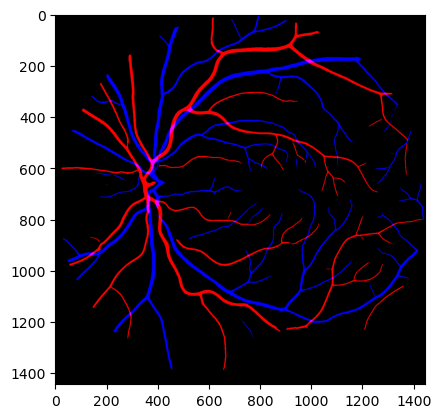

In [84]:
plt.imshow(img_np)

In [78]:
pwd

'/home/renee.zac/LabCourse'

In [79]:
ls

lunet2/  lunet2.zip  mbrset_lunout/  VBMGen.ipynb


In [ ]:
for im in image_list[:16]:
    image = Image.open(os.path.join(DATASET_PATH, image_list[0])).resize((INPUT_SIZE, INPUT_SIZE))
    input_data = transforms.ToTensor()(image)
    input_data = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)(input_data)
    input_data = np.expand_dims(input_data, axis=0)
    out_torch  = model(torch.tensor(input_data, dtype=torch.float32))


In [23]:
image = Image.open(os.path.join(DATASET_PATH, image_list[0])).resize((INPUT_SIZE, INPUT_SIZE))

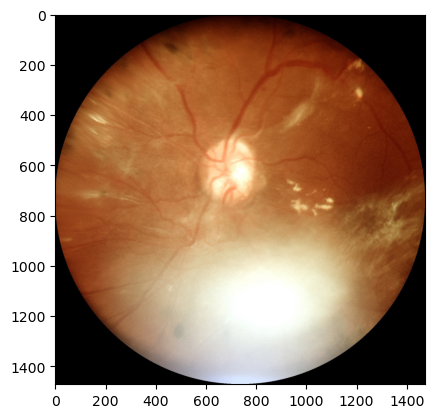

In [27]:
plt.imshow(image)

In [32]:
input_data = transforms.ToTensor()(image)
input_data = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)(input_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


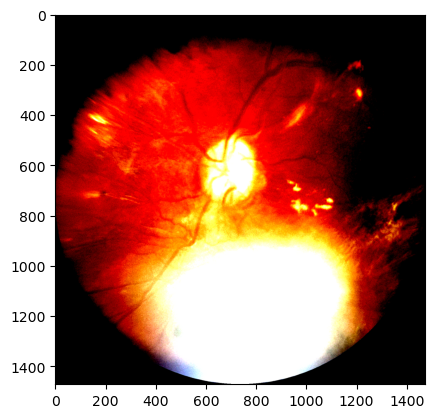

In [30]:
plt.imshow(input_data.permute(1, 2, 0))

In [33]:
input_data = np.expand_dims(input_data, axis=0)

In [34]:
out_torch  = model(torch.tensor(input_data, dtype=torch.float32))

In [35]:
out_torch.shape

torch.Size([1, 4, 1444, 1444])

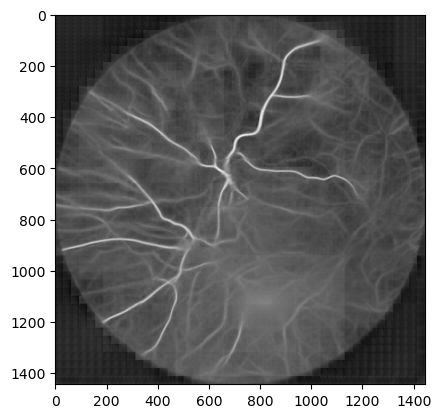

In [36]:
plt.imshow(out_torch[0, 0].detach().numpy(), cmap='gray')

In [37]:
out_torch_ = 255*(out_torch.detach().numpy()[0,:3].transpose(1,2,0))
out_torch_[:,:,2] = 0
out_torch_ = out_torch_[:,:,[0,2,1]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5283.982..3994.404].


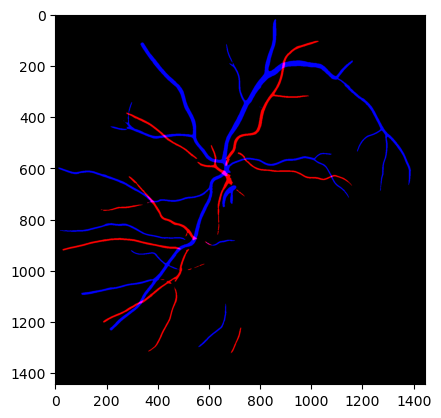

In [38]:
plt.imshow(out_torch_)

In [ ]:
np.save(os.path.join(OUT_PATH, "out_torch_.npy"), out_torch_)

In [66]:
threshold = 0.0
# flattens image to 2D array and creates binary mask
binary_mask = (out_torch_ > 0).any(axis=2).astype(np.uint8)
# presuming each channel represents artery, vein, and background
# binary_mask = (out_torch_ > threshold).astype(np.uint8)
binary_mask.shape

(1444, 1444)

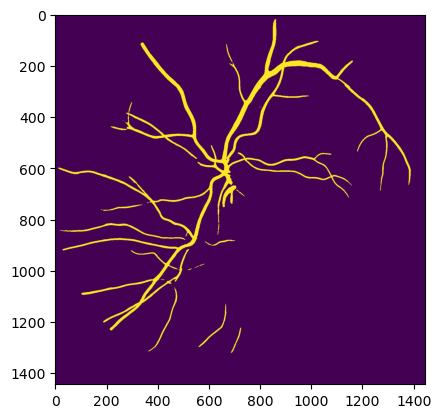

In [67]:
plt.imshow(binary_mask)

In [46]:
np.max(out_torch_)

np.float32(3994.404)

In [47]:
np.min(out_torch_)

np.float32(-5283.982)

In [48]:
np.median(out_torch_)

np.float32(-1994.135)

In [52]:
# Thresholding at 0.5 (you can change this value)
threshold = 0.0
bin_torch_ = (out_torch_ > threshold)  # or .int(), .bool() depending on your need

In [49]:
out_torch_.shape

(1444, 1444, 3)

In [50]:
out_torch.shape

torch.Size([1, 4, 1444, 1444])